# Solving the Poisson Equation

Author: Felix Hoffmann <br>
Date: 04/15/2024 <br>
Based on: [FeniCSx - Solving the Poisson Equation](https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html)

This introductory tutorial will follow along ```Hans Petter Langtangen``` and ```Anders Logg``` Tutorial on "[FEniCSx - Solving the Poisson Equation](https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html)" adapted to FEniCSx by ```Jørgen S. Dokken```.

This tutorial should not replace H.P. Lantangen's and A. Logg's tutorial. It should be more understood as a completion and application to Parameter Investigation, Parallel Computing, and Reduced Order Models. 

------------

### The Problem
We want to solve the Poisson Problem $$
    \left|
    \begin{matrix}
        -\nabla^2 u(\vec{x}) = f(\vec{x}, \vec{\alpha}) & \vec{x} \in\Omega \\
        u(\vec{x}) = u_D(\vec{x}, \vec{\beta}) & \vec{x} \in \partial\Omega
    \end{matrix}
    \right.
$$
with Parameters $\vec{\alpha}$ and $\vec{\beta}$, and the Spatial Domain $\Omega \subset \mathbb{R}^2$.

Determine the Weak Formulation by multiplying by a Test Funktion $v$, then integrate and use Green's Formula. The boundary terms are dropping out because we're using only (inhomogeneous) Dirichlet boundary conditions in this case. (Solving for $u^*$ in $u = u^* + u_D$ and therefore hom. Dirichlet.)

Therefore we're getting the weak formulation: $$
    a(u, v) = L(v) \qquad \forall v \in \hat{V}
$$
with $$ 
    \begin{matrix}
        a(u,v) = \int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}x\,,\\
        L(v)   = \int_\Omega fv\,\mathrm{d}x\,, 
    \end{matrix}
$$
and $\hat{V}$ a suitable test space. 

The last step is to build a Discretization. Based on the Triangulation and the chosen basis functions $\varphi_i(\vec{x})$ we get an approximation $$
    u(\vec{x}) \approx \sum \varphi_i(\vec{x}) \,u_h^i\,.
$$
Define $\vec{u}_h = (u_h^1,...,u_h^n)^\top$ and solve the weak formulation for the approximation $\vec{u}_h$.

----------

### Implementation

In [1]:
# Third Party Imports
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI
import ufl 
import pyvista
import vtk

from dolfinx import mesh
import dolfinx.fem as xfem
import dolfinx.plot as xplot
import dolfinx.fem.petsc as xpetsc

import trame
import ipywidgets


# Own Imports
import src.helper as helper

Before starting with the actual Problem, we want to set define the source term (or right hand side) $f(\vec{x})$ and the Dirichlet boundary conditions $u_D(\vec{x})$.

Feel free to modify these functions. For the beginning we want to stick to these because we know the exact solution in this case.

In [2]:
def sourceTerm(coords, mu) -> np.array:
    # Evaluate the source term at the spacial coordinates coords
    #   under consideration of the parameter mu.
    #
    # Args:
    #   coords (float 2xn)   Spatial 2D coordinates
    #   mu (float m)         Given Parameters
    #
    # Out:
    #   f (float n)           Evaluate f at the points x
    ############################################################

    xx = coords[0]
    yy = coords[1]

    # Feel free to modify this function
    f = mu[0] + mu[1] * np.power(xx, 2) + mu[2] * np.power(yy, 2)
    
    return f


def dirichletBoundary(coords, mu) -> np.array:
    # Evaluate the Dirichlet Boundary Fct at the spatial coordinates 
    #   coords under consideration of the parameter mu.
    #
    # Args:
    #   coords (float 2xn)   Spatial 2D coordinates
    #   mu (float m)         Given Parameters
    #
    # Out:
    #   uD (float n)           Evaluate u_D at the points x
    ############################################################

    xx = coords[0]
    yy = coords[1]

    # Feel free to modify this function
    uD = mu[0] + mu[1] * xx + mu[2] * xx * yy
    
    return uD

Let's visualize the source function and the boundary condition. Remark, that the boundary condition is strictly speaking only defined on the boundary, but here it was continued to the hole unit square $[0,1]^2$.

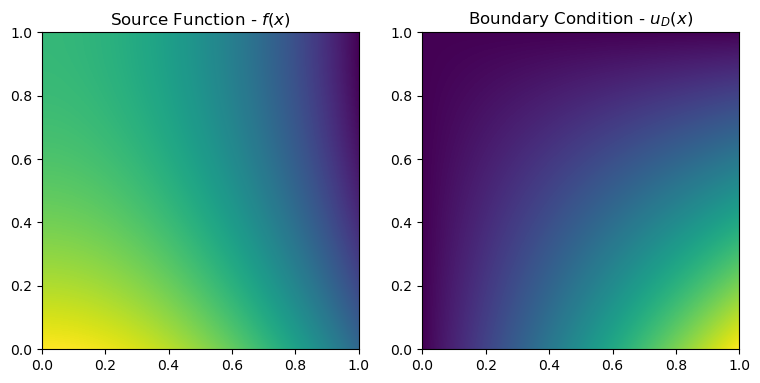

In [3]:
import src.helper as helper

alpha = [1,-2,1]
beta  = [1,0,1]

helper.plotFunctions(sourceTerm, dirichletBoundary, alpha, beta)

---

Let's start with the actual problem. First we want to set some global parameters. Like the parameters for the Source Term and Dirichlet Boundary, but also the fineness of the grid. 

In [4]:
alpha = [1,-2,1]
beta  = [1,0,1]

gridFineness = 8

---

Next we define the domain - the unit square $[0, 1]^2$.

NB: ```MPI.COMM_WORLD``` specifies how we would like the program to behave in parallel. later more about that. 

In [5]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, gridFineness, gridFineness, mesh.CellType.quadrilateral)

---
<font color='Red'> <b>ToDo:</b> </font> <br>
Make the model more complicated to run for a resonable amount of time. Experiment with the ```MPI.COMM_WORLD``` command and investigate the influence of running it in parralel via ```mpirun -n NN python file.py``` with $NN$ the number of cores. Also look into FEniCSx if it supports GPU.


---

For reference we can plot this triangulation.

Note: Install trame, trame-vtk, trame-vuetify, trame-plotly and ipywidgets!

In [6]:
helper.plotTriangulation(domain)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

---

Let's define the Finite Element Function Space $\hat{V}$ on our domain. We are using a continuous Galerkin function space. This one is equivalent to standard Lagrange family with order one. So we can use as Paramters ```"CG"``` or alternatively ```("Lagrange", 1)```. For more informations on different function spaces see [FEniCSx Function Spaces](https://fenicsproject.org/olddocs/dolfin/1.3.0/python/programmers-reference/functions/functionspace/FunctionSpace.html).

We will also define a Trial and a Test Function on that space.

In [7]:
# Function Space
V = xfem.FunctionSpace(domain, ("Lagrange", 1))

u = ufl.TrialFunction(V)   # Trial Function
v = ufl.TestFunction(V)    # Test Function

Interpolate the Source Term and Boundary Function as a Function in $\hat{V}$.
(E.g.: Projection on basis functions)

In [8]:
f = xfem.Function(V)
f.interpolate(lambda x: sourceTerm(x, alpha))

uD = xfem.Function(V)
uD.interpolate(lambda x: dirichletBoundary(x, beta))

---

Now we are defining the boundary conditions. 
First we start with some pre processing to calculate the facets representing the outer boundary. With that data we can create the (Dirichlet) boundary conditions.

In [9]:
### Pre Processing ###
tdim = domain.topology.dim    # Dimension of Simplex (Triangle/Tetrahedron)
fdim = tdim - 1               # Dimension of Facets (Sides of Simplex)

# Create connectivity between given pair of dimensions, d0 -> d1
#   ! No clue what that means, but it's necesary! :/
domain.topology.create_connectivity(fdim, tdim) 

# Get Facets representing outer boundary (needed for boundary condition)
boundary_facets = mesh.exterior_facet_indices(domain.topology)


### Define Boundary Conditions ###
boundary_dofs = xfem.locate_dofs_topological(V, fdim, boundary_facets) # global -> local coordinates
bc = xfem.dirichletbc(uD, boundary_dofs) # Assign Dirichlet Boundary conditions to boundary

---

We are now all set to define the variational problem. With the packages ```dolfinx``` and ```ufl``` this is quite intuitive. <br>
- The gradient $\nabla u$ is programmed by ```ufl.grad(u)```.
- The integration over the domain $\Omega$ is programmed by ```ufl.dx```.
- The dot product $\vec{x} \cdot \vec{y}$ is programmed by ```ufl.dot(x, y)``` or ```ufl.inner(x, y)```.
- The product $u\cdot v$ is programmed by ```u*v```

In [10]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

---

Now we are able to solve the problem. We are using the ```fem.petsc.LinearProblem```. There are other solvers out there, but for a simple linear problem, like we have it here, this is the simplest one.

In [11]:
### Solve Linear System ###
problem = xpetsc.LinearProblem(a, L, bcs=[bc])
uh = problem.solve()

# Transform Solution to np.array
solVec = uh.x.array

---
<font color='Red'> <b>ToDo:</b> </font> <br>
Look into the different solvers. Especially the solver which uses the assembled forms, see [here](https://jsdokken.com/dolfinx-tutorial/chapter2/diffusion_code.html). Compare speed (especially regarding offline/online calculation), use ```dolfinx`.fem.Constant``` for reducing simulation speed for different parameters. Also exploit the LU-decomposition of the scalar 

---

Now you could calculate the error of our approximation. I will skip that here. 

---

We are now plotting the solution for a visual reference. 

In [12]:
pyvista.start_xvfb()
topology, cell_types, geometry = xplot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

u_topology, u_cell_types, u_geometry = xplot.vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [13]:
# Plot in 3D
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)

plotter2.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…